## model loading and testing

In [1]:
import torch
import joblib
from datetime import datetime
import torch
import torch.nn as nn
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import numpy as np
import random
import os
import yaml
import seaborn as sns
from utils import parse_pv_yml
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from lume_model.utils import variables_from_yaml, variables_as_yaml
from lume_model.models import TorchModel, TorchModule
import warnings
warnings.filterwarnings("ignore")

/sdf/data/ad/ard/u/zihanzhu/miniconda3/envs/ml_gpu/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# NOTE
# 
# 2025-08-07_14-09-26_nn : use data since July 2023, Top 100 PVs from analysis, sub‐sampling = 5
# 2025-08-08_11-49-49_nn: use data since July 2023, Top 100 PVs from analysis, all data

In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
map_loc=torch.device(device)

In [4]:
model_path = '/sdf/data/ad/ard/u/zihanzhu/ml/lcls_fel_tuning/model/'
# Specify the model foldel
model_version = '2025-08-08_11-49-49_nn/'#2025-06-12_19-44-47_nn/'#'2025-04-09_04-18-25_nn/' #'2025-03-26_01-09-00_nn/'#'2025-03-03_21-15-44_nn/' #'2025-02-28_14-15-56_nn//'

loaded_model_path = model_path + model_version + 'final_lcls_fel_model.pt'
loaded_input_scaler_path = model_path + model_version + 'lcls_fel_input_scaler.pt'
loaded_output_scaler_path = model_path + model_version + 'lcls_fel_output_scaler.pt'
test_losses = np.load(model_path + model_version + 'test_losses.npy')
train_losses = np.load(model_path + model_version + 'train_losses.npy')
# Load the model state dictionary
model = torch.load(loaded_model_path, weights_only=False, map_location=map_loc)

# Load the model state dictionary
input_scaler = torch.load(loaded_input_scaler_path, weights_only=False, map_location=map_loc)
output_scaler = torch.load(loaded_output_scaler_path, weights_only=False, map_location=map_loc)
# Load the input and output variables
input_variables, output_variables = variables_from_yaml(model_path + model_version + 'feature_config.yml')


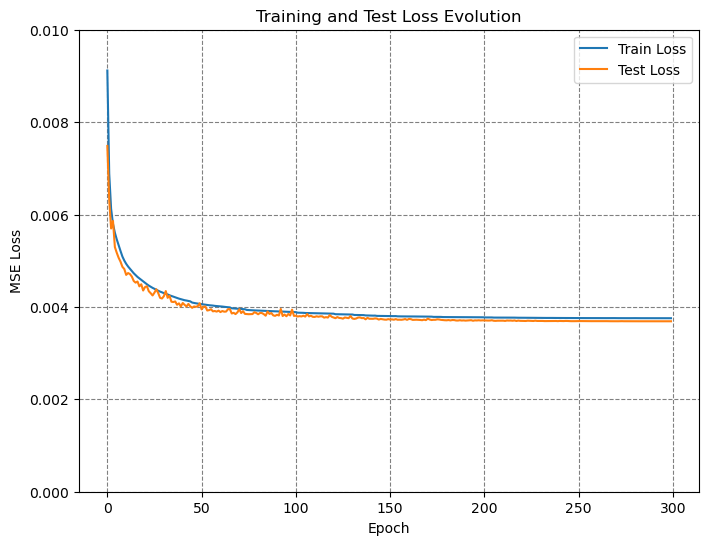

In [5]:
# Plot the training and test losses
plt.figure(figsize=(8, 6))
plt.plot(train_losses, label='Train Loss')
plt.plot(test_losses, label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('MSE Loss')
plt.grid(color="gray", linestyle="dashed")
plt.title('Training and Test Loss Evolution')
plt.ylim([0,0.01])
plt.legend()
plt.show()

In [6]:
parsed_variables = parse_pv_yml(model_path + model_version + 'feature_config.yml')

variable_ranges = {}
for variable_name in parsed_variables['input_variables']:
    var_range = parsed_variables['input_variables'][variable_name].get('value_range')
    if var_range:
        variable_ranges[variable_name] = var_range
variable_ranges

{'QUAD:IN20:122:BCTRL': [-0.015, 0.013877435475847189],
 'HXR photon energy [eV]': [7000.003878649642, 29490.9024639905],
 'ACCL:LI25:1:ADES': [3485.9381114624007, 11064.599700076029],
 'QUAD:LI30:601:BCTRL': [11.224261991960812, 19.483817026274227],
 'YCOR:UNDH:2780:BCTRL': [-0.0011104298710889794, 0.005263],
 'SOLN:IN20:121:BCTRL': [0.0, 0.5055291795264196],
 'QUAD:LI24:740:BCTRL': [-2.1, 2.0],
 'QUAD:LI22:501:BCTRL': [-5.762022444205207, -3.1463969558967753],
 'YCOR:UNDH:4080:BCTRL': [-0.0012436271683212315, 0.0009],
 'QUAD:LI30:701:BCTRL': [-19.807074319472832, -11.29247165905632],
 'QUAD:LI23:901:BCTRL': [-10.765814030877912, -5.816322382596585],
 'QUAD:LI24:201:BCTRL': [6.811574221366683, 11.965668076253683],
 'YCOR:UNDH:1480:BCTRL': [-0.006058535, 0.002548799931927693],
 'QUAD:LI30:501:BCTRL': [-19.207602268231817, -11.170202339433299],
 'QUAD:LI22:601:BCTRL': [1.065568199999996, 6.909197774314891],
 'QUAD:LI30:801:BCTRL': [13.696740574283623, 24.38199374343425],
 'QUAD:LI22:701

## Create a LUME model to wrap input, output transformers and neural network intor TorchModule

In [7]:
# create TorchModel
lume_model = TorchModel(
    model=model,
    input_variables=input_variables,
    output_variables=output_variables,
    input_transformers=[input_scaler],
    output_transformers=[output_scaler],
)



In [8]:
lume_model.input_validation_config = {
    pv_name: "none"
    for pv_name in variable_ranges.keys()
}

In [9]:
# wrap in TorchModule
lume_module = TorchModule(
    model=lume_model,
    input_order=lume_model.input_names,
    output_order=lume_model.output_names,
)

lume_module

TorchModule(
  (base_model): Sequential(
    (0): Linear(in_features=100, out_features=512, bias=True)
    (1): ELU(alpha=1.0)
    (2): Linear(in_features=512, out_features=512, bias=True)
    (3): ELU(alpha=1.0)
    (4): Linear(in_features=512, out_features=256, bias=True)
    (5): ELU(alpha=1.0)
    (6): Linear(in_features=256, out_features=128, bias=True)
    (7): ELU(alpha=1.0)
    (8): Dropout(p=0.05, inplace=False)
    (9): Linear(in_features=128, out_features=64, bias=True)
    (10): ELU(alpha=1.0)
    (11): Dropout(p=0.05, inplace=False)
    (12): Linear(in_features=64, out_features=16, bias=True)
    (13): ELU(alpha=1.0)
    (14): Dropout(p=0.05, inplace=False)
    (15): Linear(in_features=16, out_features=16, bias=True)
    (16): ELU(alpha=1.0)
    (17): Linear(in_features=16, out_features=1, bias=True)
  )
  (input_transformers_0): AffineInputTransform()
  (output_transformers_0): AffineInputTransform()
)

## Test model performance 

In [10]:
# new filters June 20th
def dataset_filter(dataset):
    # Filtering based on multiple conditions
    condition = (dataset['ACCL:LI21:1:L1S_S_PV'] < 0) & (dataset['ACCL:LI21:1:L1S_S_AV'] > 100) & \
                (dataset['ACCL:LI22:1:ADES'] > 3000) &  (dataset['ACCL:LI22:1:ADES'] < 5400) & \
                (dataset['XRMS on VCC'] > 300) & (dataset['XRMS on VCC'] < 350) & \
                (dataset['YRMS on VCC'] > 250) & (dataset['YRMS on VCC'] < 350) & \
                (dataset['hxr_pulse_intensity'] > 0.1) & (dataset['hxr_pulse_intensity'] < 4.5) & \
               (dataset['Charge at gun [pC]'] > 240) & (dataset['Charge at gun [pC]'] < 260) & \
                (dataset['Charge after BC1 [pC]'] < 200) & \
                (dataset['HXR electron energy [GeV]'] > 8) & (dataset['HXR photon energy [eV]'] > 7000)
                # all_df['hxr_pulse_intensity'] > 0.05)
    return dataset[condition]
                # (dataset['Bunch length at BC1'] > 200) & (dataset['Bunch length at BC1'] < 300) & \
                # (dataset['Bunch length at BC2'] > 3e3) & (dataset['Bunch length at BC2'] < 1e5) & \


In [22]:
base_dir = '/sdf/data/ad/ard/u/zihanzhu/ml/lcls_fel_tuning/dataset'
test_files = [
    'hxr_archiver_2025-03.pkl',
    'hxr_archiver_2025-04.pkl',

]
filter_time_frame = 0

frames = []
for fname in test_files:
    full_path = os.path.join(base_dir, fname)
    df = pd.read_pickle(full_path)
    df = dataset_filter(df)
    frames.append(df)


data_from_archiver = pd.concat(frames, axis=0)


if filter_time_frame:
    start_time = pd.Timestamp('2025-06-01 00:00:00').tz_localize('US/Pacific')
    end_time   = pd.Timestamp('2025-06-10 00:00:00').tz_localize('US/Pacific')
    test_set = data_from_archiver.loc[start_time:end_time]
else:
    test_set = data_from_archiver

print('test set size:', test_set.shape[0])

test set size: 2536525


In [23]:
# Define the fractions of the total number of rows for the selected validation set
selected_ranges = [(0, 1)]
subsample_step = 2
test_set = test_set.iloc[:: subsample_step]

selected_validation_set = pd.DataFrame()
for start_fraction, end_fraction in selected_ranges:
    start_index = int(start_fraction * len(test_set))
    end_index = int(end_fraction * len(test_set))
    subset = test_set.iloc[start_index:end_index]
    selected_validation_set = pd.concat([selected_validation_set, subset])
    
x_index  = selected_validation_set.index
y_true = selected_validation_set[lume_model.output_names]             # 1-column DF
y_pred = lume_module(torch.tensor(selected_validation_set[lume_model.input_names]
                                     .values, dtype=torch.float32)).flatten()

y_true_np = y_true.values.flatten()      # 1-D arrays expected by sklearn
y_pred_np = np.asarray(y_pred)

mae  = mean_absolute_error(y_true_np, y_pred_np)
# rmse = mean_squared_error(y_true_np, y_pred_np, squared=False)
r2   = r2_score(y_true_np, y_pred_np)

In [24]:
# Rolling statistics
window = 50
y_mean = y_true.rolling(window=window).mean()
y_perc80 = y_true.rolling(window=window).quantile(0.80)   # 80-th percentile
y_perc20 = y_true.rolling(window).quantile(0.20)

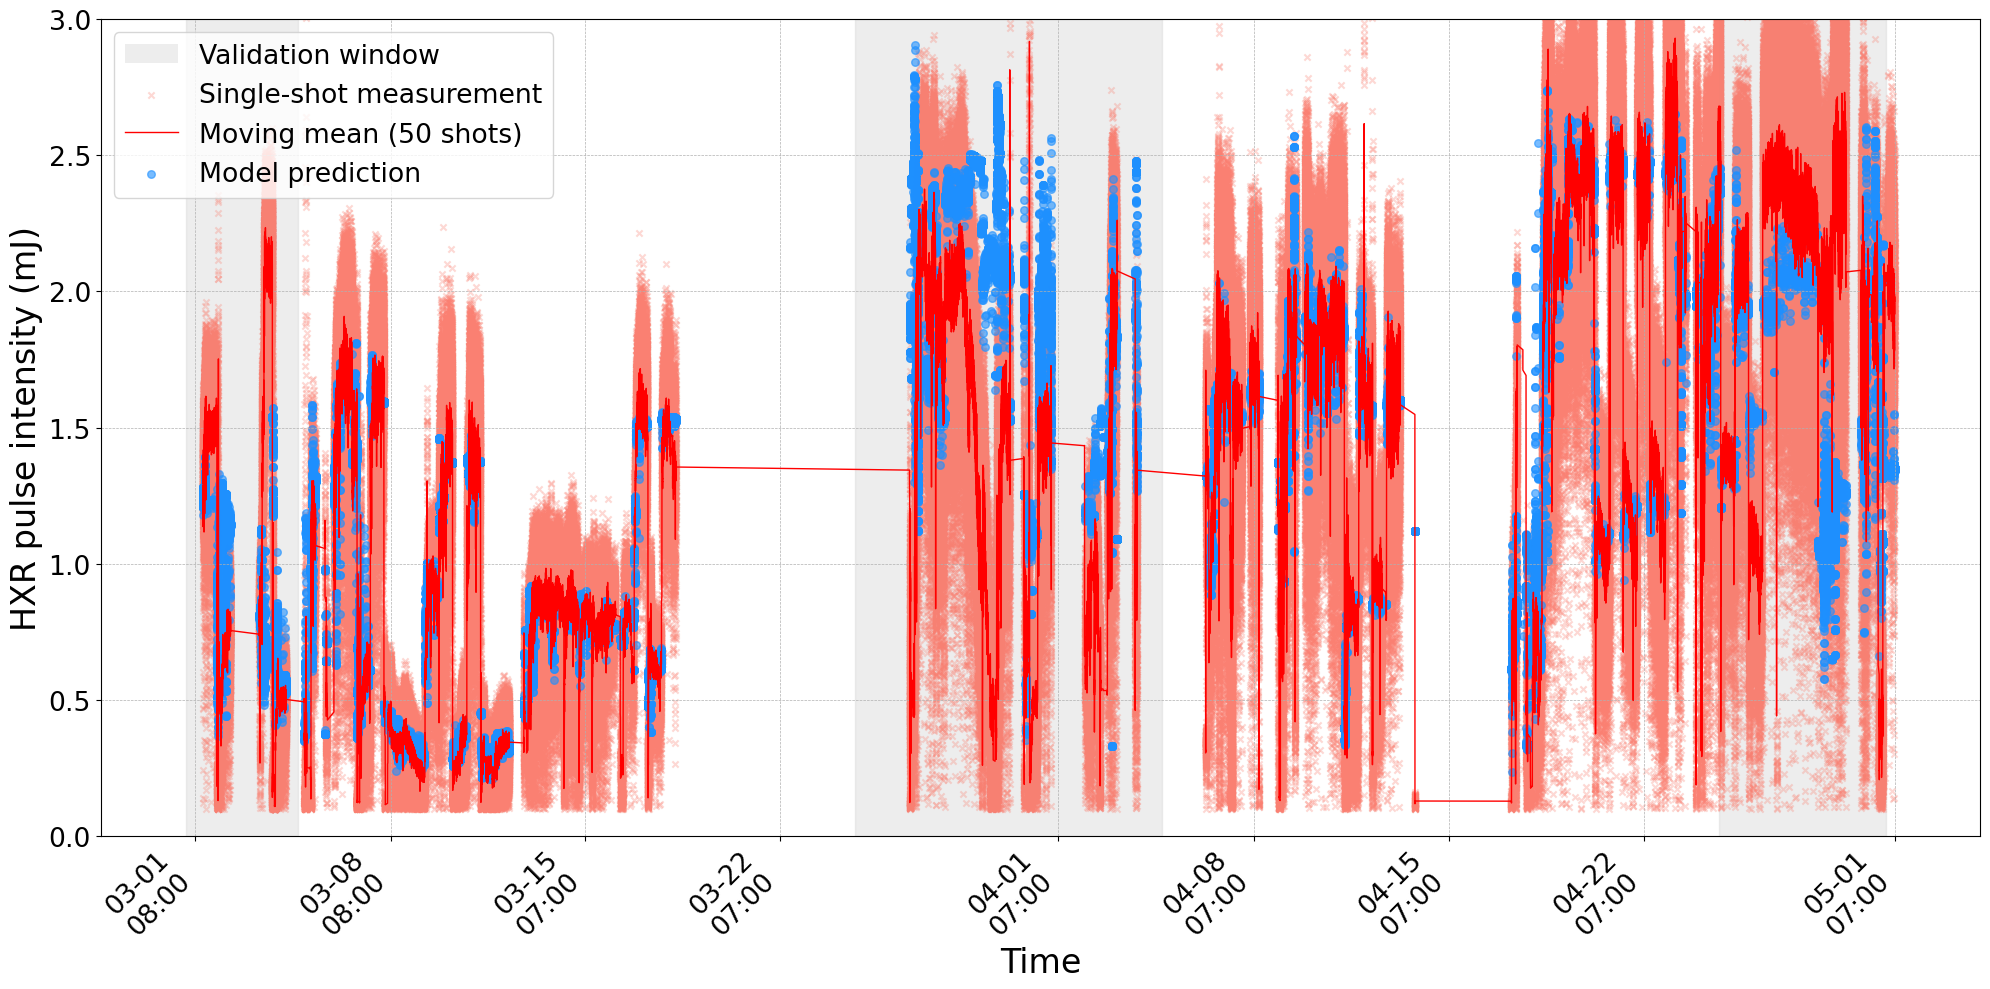

  MAE  :   0.3424  mJ


In [25]:
from matplotlib.dates import AutoDateLocator, ConciseDateFormatter

validation_windows = [
    ("2025-03-01 00:00", "2025-03-05 00:00"),
    ("2025-03-25 00:00", "2025-04-05 00:00"),
    ("2025-04-25 00:00", "2025-05-01 00:00"),
]

start = pd.to_datetime("2025-03-01 00:00:00").tz_localize("US/Pacific")
end   = pd.to_datetime("2025-04-10 00:00:00").tz_localize("US/Pacific")

plot_validation = 1
zoom_in = 0

if plot_validation:
    # parse into timezone‐naïve or tz‐aware timestamps matching x_index
    validation_windows = [
        (pd.to_datetime(t0), pd.to_datetime(t1))
        for t0, t1 in validation_windows
    ]
    
    plt.figure(figsize=(20, 10))
    fs = 24
    
    ax = plt.gca()
    
    # 1) Shade the validation windows
    for t0, t1 in validation_windows:
        ax.axvspan(t0, t1, color="lightgray", alpha=0.4, label="_nolegend_")

# 2) Raw measurements
ax.scatter(x_index, y_true.values,
           s=20, c="salmon", marker="x", alpha=0.3,
           label="Single-shot measurement")

# 3) Moving mean
ax.plot(x_index, y_mean, c="red", lw=1,
        label=f"Moving mean ({window} shots)")

# 4) Model prediction
ax.scatter(x_index, y_pred, c="dodgerblue", s=30, alpha=0.6,
           label="Model prediction")

# cosmetics
ax.xaxis.set_major_formatter(mdates.DateFormatter('%m-%d\n%H:%M'))
ax.set_xlabel("Time", fontsize=fs)
ax.set_ylabel("HXR pulse intensity (mJ)", fontsize=fs)
ax.set_ylim(0, 3)

# add a custom legend entry for the shaded areas once
from matplotlib.patches import Patch
shading_patch = Patch(facecolor="lightgray", alpha=0.4, label="Validation window")
ax.legend(handles=[shading_patch] + ax.get_legend_handles_labels()[0],
          fontsize=fs * 0.8, loc="upper left")


ax = plt.gca()

if zoom_in:
    ax.set_xlim(start, end)
ax.tick_params(labelsize=fs * 0.8)

# # auto‐choose “nice” tick positions
# locator = AutoDateLocator(minticks=4, maxticks=10)
# ax.xaxis.set_major_locator(locator)

# # concise labels that only show as much as needed
# formatter = ConciseDateFormatter(locator)
# ax.xaxis.set_major_formatter(formatter)

plt.setp(ax.get_xticklabels(), rotation=45, ha="right")

ax.grid(True, ls="--", lw=0.5)
plt.tight_layout()
plt.show()

# Print your MAE (and any other metrics)
print(f"  MAE  : {mae:8.4f}  mJ")

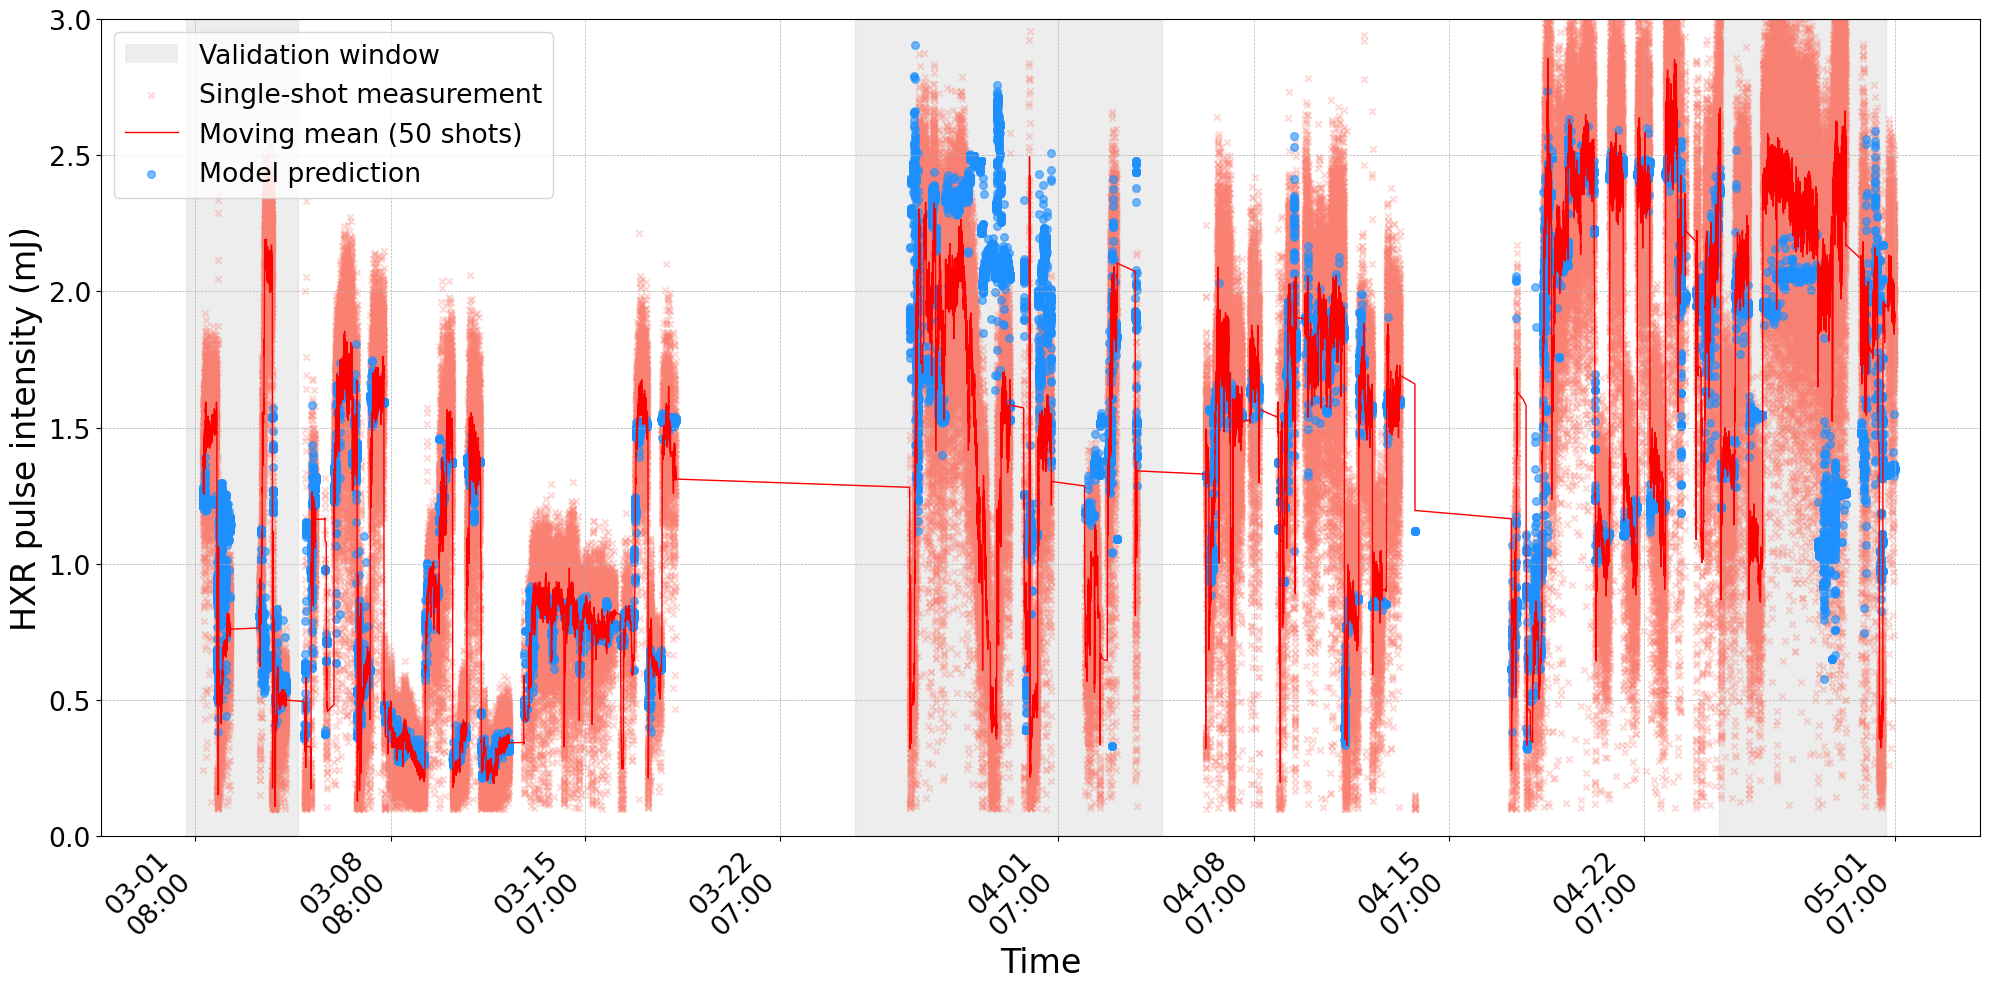

  MAE  :   0.3425  mJ


In [14]:
from matplotlib.dates import AutoDateLocator, ConciseDateFormatter

validation_windows = [
    ("2025-03-01 00:00", "2025-03-05 00:00"),
    ("2025-03-25 00:00", "2025-04-05 00:00"),
    ("2025-04-25 00:00", "2025-05-01 00:00"),
]

start = pd.to_datetime("2025-03-01 00:00:00").tz_localize("US/Pacific")
end   = pd.to_datetime("2025-04-10 00:00:00").tz_localize("US/Pacific")

plot_validation = 1
zoom_in = 0

if plot_validation:
    # parse into timezone‐naïve or tz‐aware timestamps matching x_index
    validation_windows = [
        (pd.to_datetime(t0), pd.to_datetime(t1))
        for t0, t1 in validation_windows
    ]
    
    plt.figure(figsize=(20, 10))
    fs = 24
    
    ax = plt.gca()
    
    # 1) Shade the validation windows
    for t0, t1 in validation_windows:
        ax.axvspan(t0, t1, color="lightgray", alpha=0.4, label="_nolegend_")

# 2) Raw measurements
ax.scatter(x_index, y_true.values,
           s=20, c="salmon", marker="x", alpha=0.3,
           label="Single-shot measurement")

# 3) Moving mean
ax.plot(x_index, y_mean, c="red", lw=1,
        label=f"Moving mean ({window} shots)")

# 4) Model prediction
ax.scatter(x_index, y_pred, c="dodgerblue", s=30, alpha=0.6,
           label="Model prediction")

# cosmetics
ax.xaxis.set_major_formatter(mdates.DateFormatter('%m-%d\n%H:%M'))
ax.set_xlabel("Time", fontsize=fs)
ax.set_ylabel("HXR pulse intensity (mJ)", fontsize=fs)
ax.set_ylim(0, 3)

# add a custom legend entry for the shaded areas once
from matplotlib.patches import Patch
shading_patch = Patch(facecolor="lightgray", alpha=0.4, label="Validation window")
ax.legend(handles=[shading_patch] + ax.get_legend_handles_labels()[0],
          fontsize=fs * 0.8, loc="upper left")


ax = plt.gca()

if zoom_in:
    ax.set_xlim(start, end)
ax.tick_params(labelsize=fs * 0.8)

# # auto‐choose “nice” tick positions
# locator = AutoDateLocator(minticks=4, maxticks=10)
# ax.xaxis.set_major_locator(locator)

# # concise labels that only show as much as needed
# formatter = ConciseDateFormatter(locator)
# ax.xaxis.set_major_formatter(formatter)

plt.setp(ax.get_xticklabels(), rotation=45, ha="right")

ax.grid(True, ls="--", lw=0.5)
plt.tight_layout()
plt.show()

# Print your MAE (and any other metrics)
print(f"  MAE  : {mae:8.4f}  mJ")

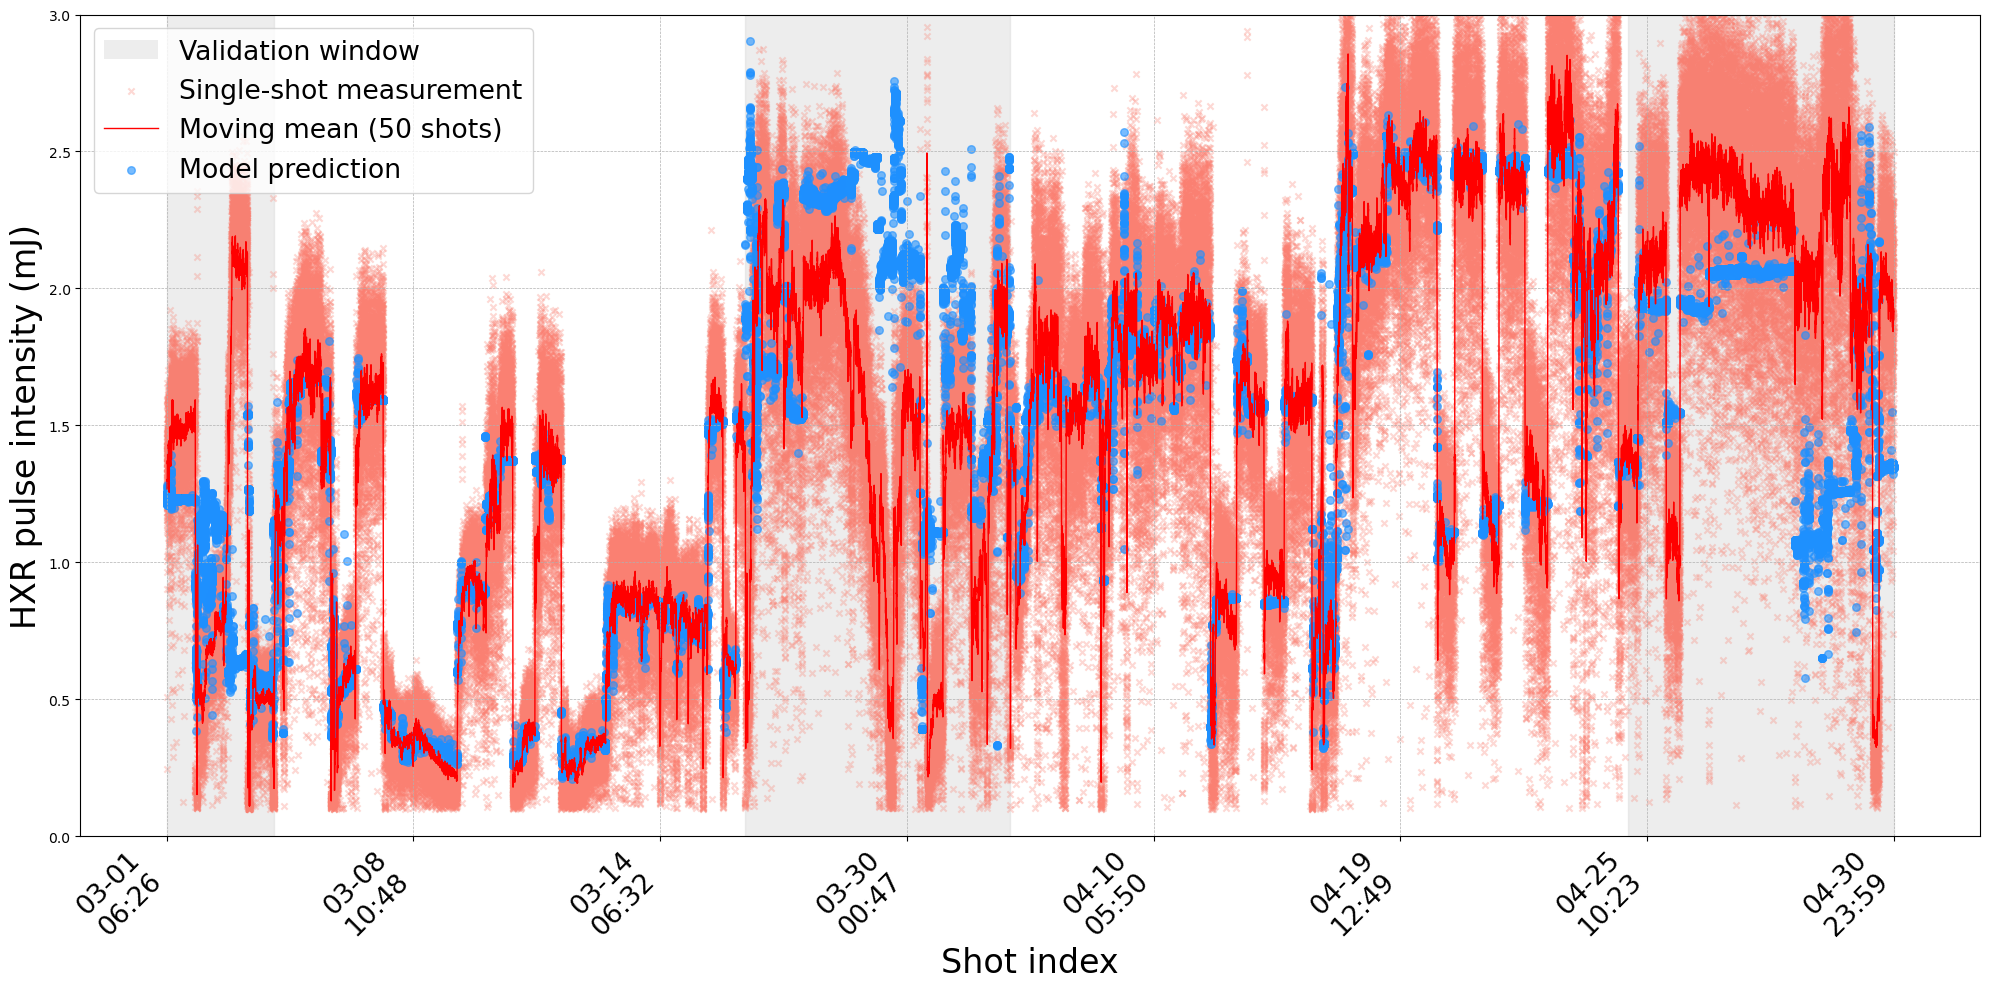

  MAE  :   0.3425  mJ


In [15]:
from matplotlib.patches import Patch

# — assume you’ve already built:
#    x_index           : a DatetimeIndex (tz=”US/Pacific”) for each shot
#    y_true, y_mean, y_pred : your three series/arrays, all aligned to x_index
#    validation_windows: list of (t0, t1) strings, e.g. [("2025-03-01 00:00","2025-03-05 00:00"), ...]

# ---- 1) build an integer x axis
x_ord = np.arange(len(x_index))

# ---- 2) convert your validation windows into ordinal ranges
val_ranges = []
for t0, t1 in validation_windows:
    t0 = pd.to_datetime(t0).tz_localize("US/Pacific")
    t1 = pd.to_datetime(t1).tz_localize("US/Pacific")
    i0 = x_index.searchsorted(t0)
    i1 = x_index.searchsorted(t1)
    val_ranges.append((i0, i1))

# ---- 3) plotting
fig, ax = plt.subplots(figsize=(20,10))
fs = 24

# shade the validation spans
for (i0, i1) in val_ranges:
    ax.axvspan(i0, i1, color="lightgray", alpha=0.4, label="_nolegend_")

# raw single‐shot
ax.scatter(x_ord, y_true.values,
           s=20, c="salmon", marker="x", alpha=0.3,
           label="Single‐shot measurement")

# moving mean
ax.plot(x_ord, y_mean, c="red", lw=1,
        label=f"Moving mean ({window} shots)")

# model prediction
ax.scatter(x_ord, y_pred, c="dodgerblue", s=30, alpha=0.6,
           label="Model prediction")

# cosmetics
shading_patch = Patch(facecolor="lightgray", alpha=0.4, label="Validation window")
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles=[shading_patch] + handles,
          labels=["Validation window"] + labels,
          fontsize=fs*0.8, loc="upper left")

ax.set_ylim(0, 3)
ax.set_ylabel("HXR pulse intensity (mJ)", fontsize=fs)
ax.set_xlabel("Shot index", fontsize=fs)

# pick a handful of ticks and label them with their real dates
# here we pick 8 evenly‐spaced ticks:
n_ticks = 8
tick_pos = np.linspace(0, len(x_ord)-1, n_ticks, dtype=int)
tick_lbl = [x_index[i].strftime("%m-%d\n%H:%M") for i in tick_pos]
ax.set_xticks(tick_pos)
ax.set_xticklabels(tick_lbl, rotation=45, ha="right", fontsize=fs*0.8)

ax.grid(True, ls="--", lw=0.5)
plt.tight_layout()
plt.show()

print(f"  MAE  : {mae:8.4f}  mJ")

In [55]:
def print_out_of_range_pvs(test_df, variable_ranges, tolerance=1e-6):
    """
    Prints variables in test_df that fall outside the specified ranges.

    Args:
        test_df (pd.DataFrame): DataFrame with test data.
        variable_ranges (dict): Dict of {variable: [min, max]}.
        tolerance (float): Small buffer to ignore floating point rounding errors.
    """
    total_samples = len(test_df)
    print(f"\nTotal test samples: {total_samples}\nOut-of-range PV report:\n{'-'*50}")
    any_violations = False

    for var, (lower, upper) in variable_ranges.items():
        if var not in test_df.columns:
            print(f"⚠️  Skipping {var} (not in test set)")
            continue

        values = test_df[var]
        below = (values < lower - tolerance).sum()
        above = (values > upper + tolerance).sum()
        total_out = below + above

        if total_out > 0:
            any_violations = True
            percent = 100 * total_out / total_samples
            print(f"{var}: {total_out} out of {total_samples} ({percent:.2f}%) out of range "
                  f"[{lower:.3f}, {upper:.3f}] → {below} below, {above} above")

    if not any_violations:
        print("✅ All variables are within specified ranges.")

# Usage
print_out_of_range_pvs(test_set, variable_ranges)



Total test samples: 892567
Out-of-range PV report:
--------------------------------------------------
QUAD:LI21:271:BCTRL: 2726 out of 892567 (0.31%) out of range [-7.229, -2.515] → 2726 below, 0 above
QUAD:LI21:601:BCTRL: 5342 out of 892567 (0.60%) out of range [1.380, 2.021] → 5342 below, 0 above
QUAD:LI21:701:BCTRL: 5342 out of 892567 (0.60%) out of range [-2.518, -1.707] → 0 below, 5342 above
QUAD:LI21:801:BCTRL: 5342 out of 892567 (0.60%) out of range [2.256, 3.112] → 5342 below, 0 above
QUAD:LI21:901:BCTRL: 2098 out of 892567 (0.24%) out of range [-3.626, -2.284] → 0 below, 2098 above
QUAD:LI22:201:BCTRL: 5342 out of 892567 (0.60%) out of range [2.664, 3.678] → 5342 below, 0 above
QUAD:LI22:301:BCTRL: 96330 out of 892567 (10.79%) out of range [-4.412, -3.321] → 90988 below, 5342 above
QUAD:LI22:401:BCTRL: 5342 out of 892567 (0.60%) out of range [3.554, 5.304] → 5342 below, 0 above
QUAD:LI22:501:BCTRL: 190062 out of 892567 (21.29%) out of range [-5.566, -3.955] → 184720 below, 53

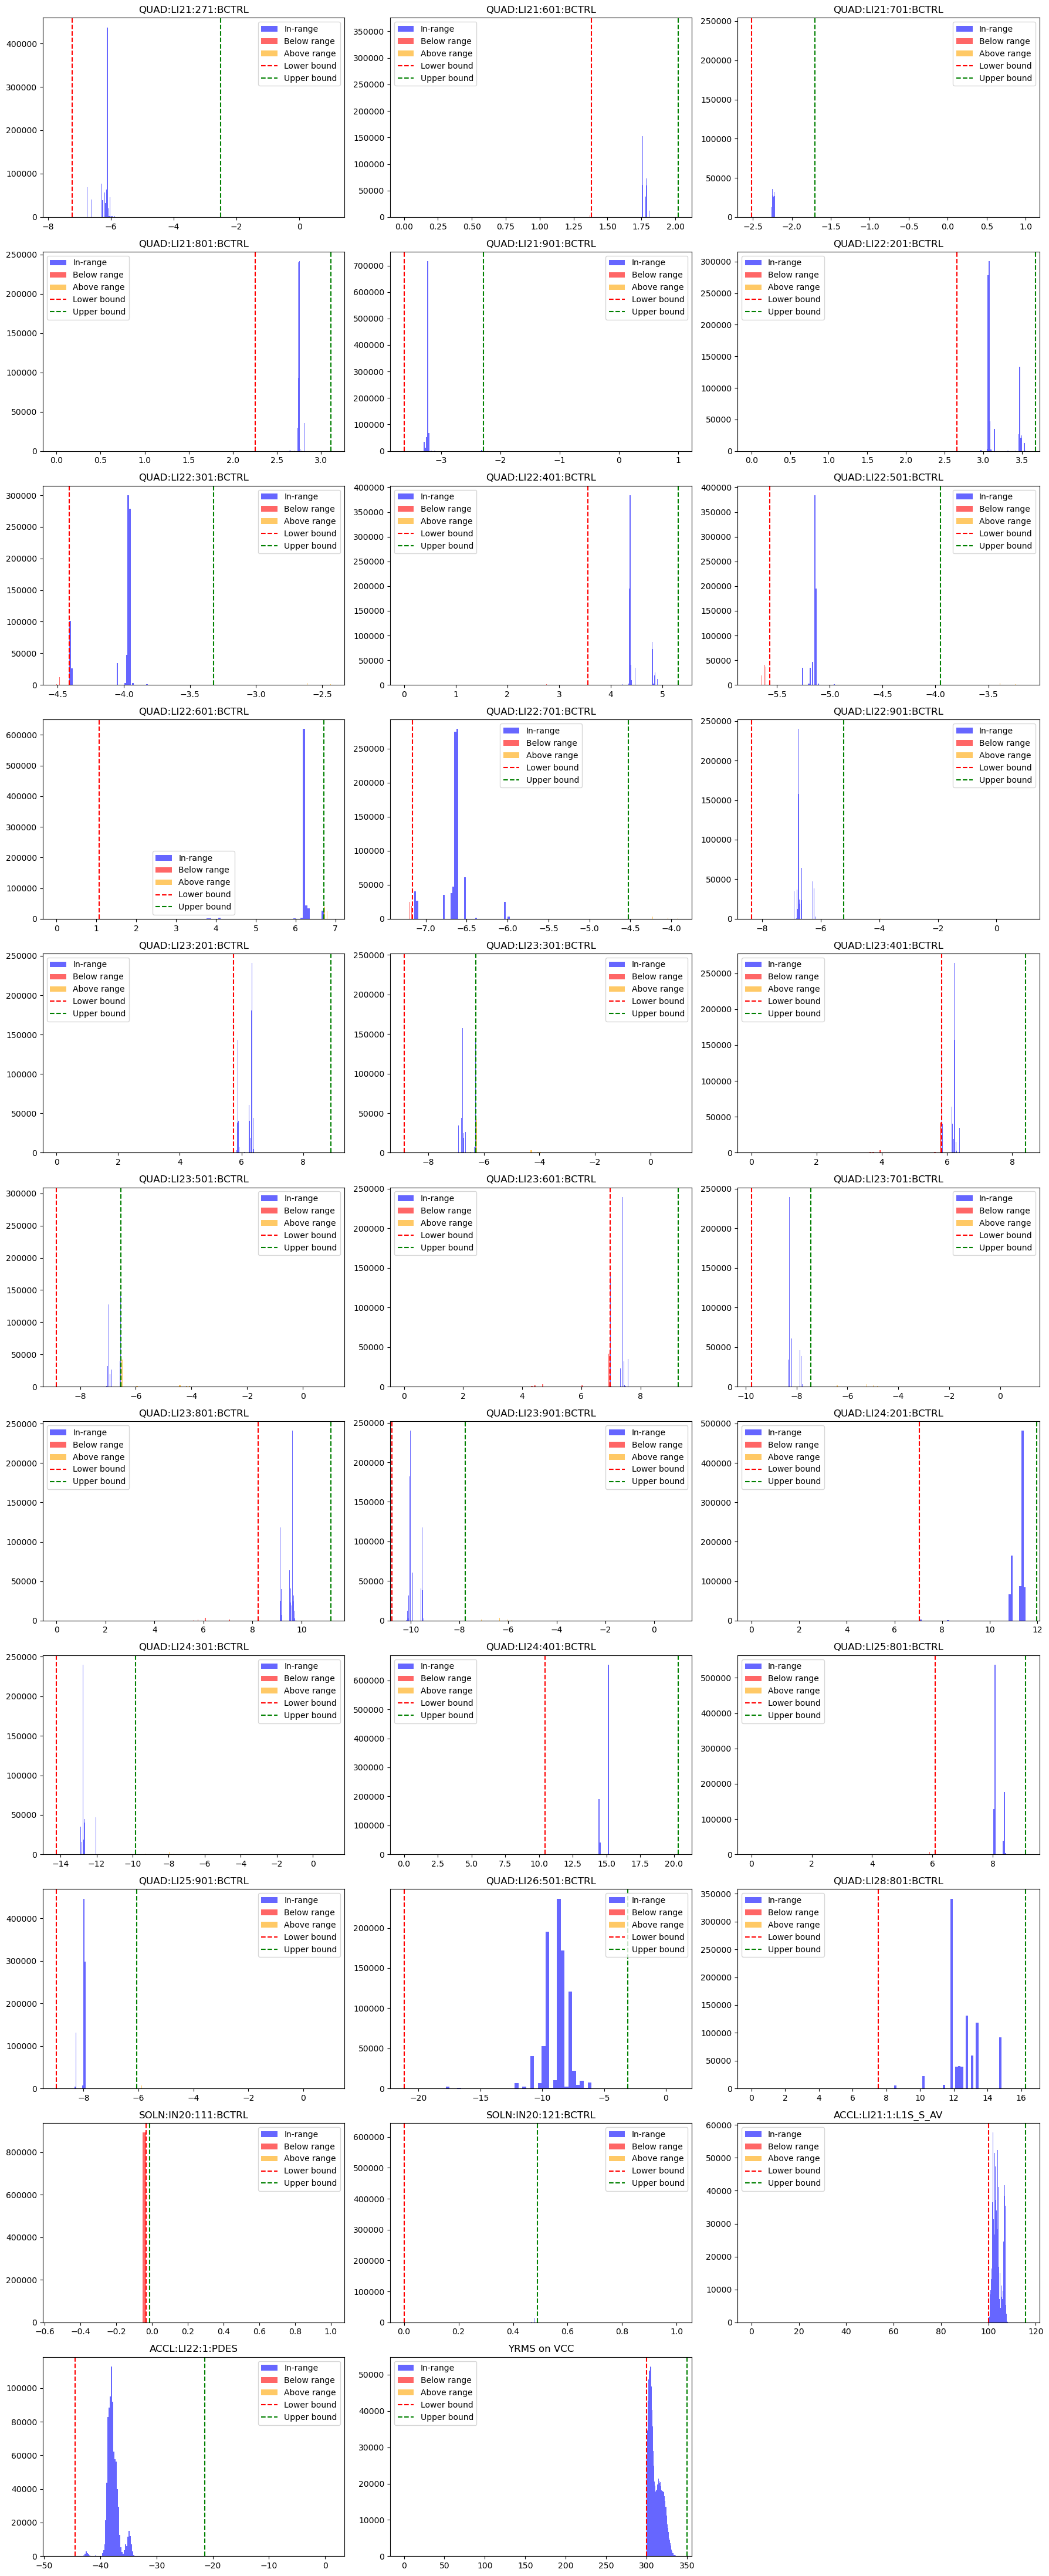

In [56]:
def plot_out_of_range_pvs(test_df, variable_ranges, tolerance=1e-6, bins=50):
    """
    Plot histograms of variables showing out-of-range samples in red.
    
    Args:
        test_df (pd.DataFrame): DataFrame of test data.
        variable_ranges (dict): Dictionary of {var: [min, max]}.
        tolerance (float): Allowed tolerance for boundary checks.
        bins (int): Number of bins for histograms.
    """
    out_of_range_vars = []

    for var, (lower, upper) in variable_ranges.items():
        if var not in test_df.columns:
            continue
        values = test_df[var]
        below = values < lower - tolerance
        above = values > upper + tolerance
        out_of_range = below | above

        if out_of_range.any():
            out_of_range_vars.append((var, values, below, above))

    n = len(out_of_range_vars)
    if n == 0:
        print("✅ All variables are within range. No plot needed.")
        return

    cols = 3
    rows = (n + cols - 1) // cols
    fig, axes = plt.subplots(rows, cols, figsize=(6 * cols, 4 * rows))
    axes = axes.flatten()

    for i, (var, values, below, above) in enumerate(out_of_range_vars):
        ax = axes[i]
        ax.hist(values[~(below | above)], bins=bins, alpha=0.6, label='In-range', color='blue')
        ax.hist(values[below], bins=bins, alpha=0.6, label='Below range', color='red')
        ax.hist(values[above], bins=bins, alpha=0.6, label='Above range', color='orange')
        ax.axvline(variable_ranges[var][0], color='red', linestyle='--', label='Lower bound')
        ax.axvline(variable_ranges[var][1], color='green', linestyle='--', label='Upper bound')
        ax.set_title(var)
        ax.legend()

    # Hide unused subplots
    for j in range(i + 1, len(axes)):
        fig.delaxes(axes[j])

    plt.tight_layout()
    plt.show()

# Usage
plot_out_of_range_pvs(test_set, variable_ranges)


In [44]:
def scan_model_response_1D(model, input_scaler, output_scaler, variable_ranges, input_names, n_points=100):
    model.eval()

    # Compute midpoints for all variables
    midpoints = {var: (bounds[0] + bounds[1]) / 2 for var, bounds in variable_ranges.items()}

    for var_to_scan in input_names:
        if var_to_scan not in variable_ranges:
            print(f"Skipping {var_to_scan} (no range info)")
            continue
        
        scan_vals = np.linspace(*variable_ranges[var_to_scan], n_points)
        input_batch = []

        for val in scan_vals:
            sample = [val if var == var_to_scan else midpoints[var] for var in input_names]
            input_batch.append(sample)

        input_batch = np.array(input_batch)
        input_tensor = input_scaler.transform(torch.tensor(input_batch, dtype=torch.float32))

        with torch.no_grad():
            output_scaled = model(input_tensor)
            output_unscaled = output_scaler.untransform(output_scaled).numpy().flatten()

        # Plotting
        plt.figure(figsize=(6, 4))
        plt.plot(scan_vals, output_unscaled, label='FEL Energy')
        plt.title(f'Model Response to {var_to_scan}')
        plt.xlabel(var_to_scan)
        plt.ylabel('Predicted FEL Pulse Energy (mJ)')
        plt.grid(True)
        plt.tight_layout()
        plt.show()


In [45]:
scan_model_response_1D(model, input_scaler, output_scaler, variable_ranges, input_names=lume_model.input_names)


BotorchTensorDimensionError: Wrong input dimension. Received 114, expected 115.

In [46]:
# Compare input_names with variable_ranges keys
missing_vars = [var for var in lume_model.input_names if var not in variable_ranges]
print("Missing variable(s) in variable_ranges:", missing_vars)


Missing variable(s) in variable_ranges: []


In [52]:
import torch

# Construct a single input vector from midpoints
input_names = lume_model.input_names
single_input = []

for name in input_names:
    try:
        lower, upper = variable_ranges[name]
        midpoint = (lower + upper) / 2
        single_input.append(midpoint)
    except KeyError:
        print(f"Missing in variable_ranges: {name}")

# Convert to tensor
single_input_tensor = torch.tensor([single_input], dtype=torch.float32)

print("Single input tensor shape:", single_input_tensor.shape)
print("Expected input dimension from scaler:", input_scaler.offset.shape[-1])

# Try scaling
try:
    input_scaled = input_scaler.transform(single_input_tensor)
    print("Scaling successful. Shape:", input_scaled.shape)
except Exception as e:
    print("Scaling error:", e)
    input_scaled = None

# Predict only if scaling worked
if input_scaled is not None:
    try:
        with torch.no_grad():
            output_scaled = model(input_scaled)
            output = output_scaler.untransform(output_scaled)
        print("Model prediction:", output)
    except Exception as e:
        print("Model prediction error:", e)


Single input tensor shape: torch.Size([1, 114])
Expected input dimension from scaler: 115
Scaling error: Wrong input dimension. Received 114, expected 115.


In [69]:
def check_filter_conditions(dataset):
    conditions = {
        "ACCL:LI21:1:L1S_S_PV < 0": dataset['ACCL:LI21:1:L1S_S_PV'] < 0,
        "ACCL:LI21:1:L1S_S_AV > 100": dataset['ACCL:LI21:1:L1S_S_AV'] > 100,
        "ACCL:LI22:1:ADES > 3000": dataset['ACCL:LI22:1:ADES'] > 3000,
        "ACCL:LI22:1:ADES < 5300": dataset['ACCL:LI22:1:ADES'] < 5300,
        "XRMS on VCC > 300": dataset['XRMS on VCC'] > 300,
        "XRMS on VCC < 350": dataset['XRMS on VCC'] < 350,
        "YRMS on VCC > 300": dataset['YRMS on VCC'] > 300,
        "YRMS on VCC < 350": dataset['YRMS on VCC'] < 350,
        "hxr_pulse_intensity > 0.02": dataset['hxr_pulse_intensity'] > 0.02,
        "hxr_pulse_intensity < 4.5": dataset['hxr_pulse_intensity'] < 4.5,
        "Charge at gun [pC] > 240": dataset['Charge at gun [pC]'] > 240,
        "Charge at gun [pC] < 260": dataset['Charge at gun [pC]'] < 260,
        "Charge after BC1 [pC] < 200": dataset['Charge after BC1 [pC]'] < 200,
        "HXR electron energy [GeV] > 8": dataset['HXR electron energy [GeV]'] > 8,
        "HXR photon energy [eV] > 7000": dataset['HXR photon energy [eV]'] > 7000,
    }

    total = len(dataset)
    print(f"Total samples before filtering: {total}")
    
    for desc, condition in conditions.items():
        passed = condition.sum()
        print(f"{desc}: kept {passed} / {total} ({100 * passed / total:.2f}%)")

# Example usage:
df = pd.read_pickle('/sdf/data/ad/ard/u/zihanzhu/ml/lcls_fel_tuning/dataset/hxr_archiver_June_2025.pkl')
check_filter_conditions(df)


Total samples before filtering: 566603
ACCL:LI21:1:L1S_S_PV < 0: kept 566500 / 566603 (99.98%)
ACCL:LI21:1:L1S_S_AV > 100: kept 566392 / 566603 (99.96%)
ACCL:LI22:1:ADES > 3000: kept 566603 / 566603 (100.00%)
ACCL:LI22:1:ADES < 5300: kept 291694 / 566603 (51.48%)
XRMS on VCC > 300: kept 565743 / 566603 (99.85%)
XRMS on VCC < 350: kept 565026 / 566603 (99.72%)
YRMS on VCC > 300: kept 1759 / 566603 (0.31%)
YRMS on VCC < 350: kept 565063 / 566603 (99.73%)
hxr_pulse_intensity > 0.02: kept 565763 / 566603 (99.85%)
hxr_pulse_intensity < 4.5: kept 566603 / 566603 (100.00%)
Charge at gun [pC] > 240: kept 564454 / 566603 (99.62%)
Charge at gun [pC] < 260: kept 565162 / 566603 (99.75%)
Charge after BC1 [pC] < 200: kept 566603 / 566603 (100.00%)
HXR electron energy [GeV] > 8: kept 566603 / 566603 (100.00%)
HXR photon energy [eV] > 7000: kept 566603 / 566603 (100.00%)


[300.00013463344874, 346.203243635317]


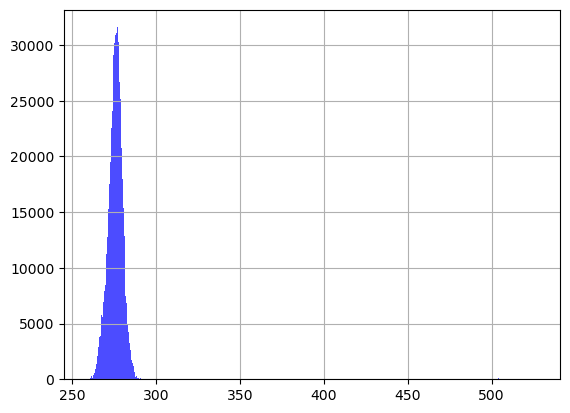

In [77]:
pv = 'YRMS on VCC'
df[pv].hist(bins=500, alpha=0.7, color='blue')
print(variable_ranges[pv])

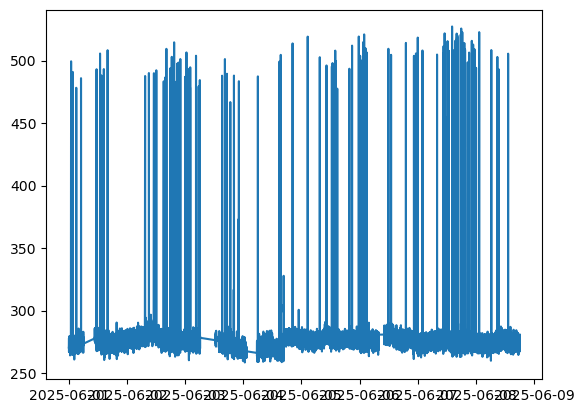

In [78]:
plt.plot(df[pv])

In [79]:
df_may = pd.read_pickle('/sdf/data/ad/ard/u/zihanzhu/ml/lcls_fel_tuning/dataset/hxr_archiver_May_2025.pkl')

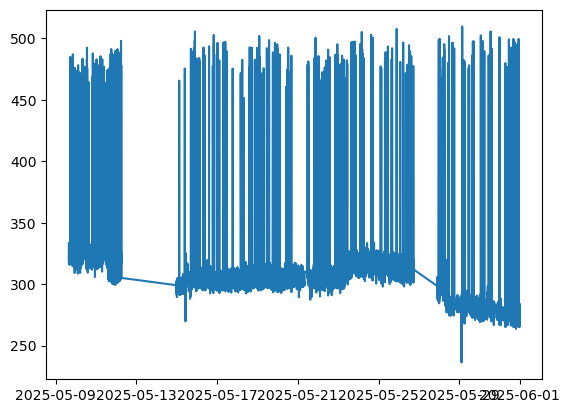

In [80]:
plt.plot(df_may[pv])

In [84]:
combined_df

QUAD:LI21:211:BCTRL  QUAD:LI21:221:BCTRL  QUAD:LI21:243:BCTRL  \
0                   5.656917             -0.08757            -0.000675   
1                   5.656917             -0.08757            -0.000675   
2                   5.656917             -0.08757            -0.000675   
3                   5.656917             -0.08757            -0.000675   
4                   5.656917             -0.08757            -0.000675   
...                      ...                  ...                  ...   
1899498             6.186750              0.01300            -0.000675   
1899499             6.186750              0.01300            -0.000675   
1899500             6.186750              0.01300            -0.000675   
1899501             6.186750              0.01300            -0.000675   
1899502             6.186750              0.01300            -0.000675   

         QUAD:LI21:251:BCTRL  QUAD:LI21:271:BCTRL  QUAD:LI21:335:BCTRL  \
0                  -0.134197            -6.292230            -5.328303   
1                  -0.134197            -6.292230            -5.328303   
2                  -0.134197            -6.292230            -5.328303   
3                  -0.134197            -6.292230            -5.328303   
4                  -0.134197            -6.292230            -5.328303   
...                      ...                  ...                  ...   
1899498            -0.103429            -5.909697            -5.328303   
1899499            -0.103429            -5.909697            -5.328303   
1899500            -0.103429            -5.909697            -5.328303   
1899501            -0.103429            -5.909697            -5.328303   
1899502            -0.103429            -5.909697            -5.328303   

         QUAD:LI24:713:BCTRL  QUAD:LI24:740:BCTRL  QUAD:LI24:860:BCTRL  \
0                  35.415961             0.159368             1.442915   
1                  35.415961             0.159368             1.442915   
2                  35.415961             0.159368             1.442915   
3                  35.415961             0.159368             1.442915   
4                  35.415961             0.159368             1.442915   
...                      ...                  ...                  ...   
1899498            35.415961            -0.033243            -0.114359   
1899499            35.415961            -0.033243            -0.114359   
1899500            35.415961            -0.033243            -0.114359   
1899501            35.415961            -0.033243            -0.114359   
1899502            35.415961            -0.033243            -0.114359   

         QUAD:LI24:892:BCTRL  ...  hxr_pulse_intensity  XRMS on VCC  \
0                 -40.782003  ...             1.896117   331.262120   
1                 -40.782003  ...             2.150529   331.262120   
2                 -40.782003  ...             1.745259   331.262120   
3                 -40.782003  ...             1.707498   331.262120   
4                 -40.782003  ...             2.261591   331.262120   
...                      ...  ...                  ...          ...   
1899498           -40.782003  ...             1.254486   307.741186   
1899499           -40.782003  ...             1.373229   307.741186   
1899500           -40.782003  ...             1.316396   307.741186   
1899501           -40.782003  ...             1.329652   307.741186   
1899502           -40.782003  ...             1.177907   307.741186   

         YRMS on VCC  Bunch length at BC1  Bunch length at BC2  \
0         322.185353           216.278558          3337.190464   
1         322.185353           224.156932          3298.523648   
2         322.185353           222.697328          3146.403961   
3         322.185353           219.471435          3306.213371   
4         322.185353           221.253555          3258.501201   
...              ...                  ...                  ...   
1899498   275.493028       

Text(0.5, 1.0, 'YRMS on VCC')

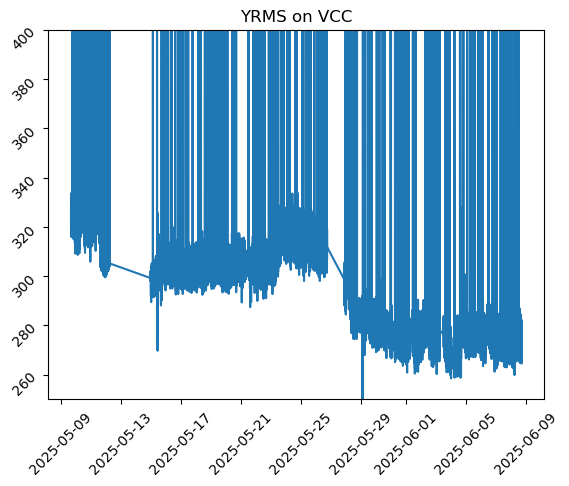

In [86]:
combined_df = pd.concat([df_may, df], axis=0)
plt.plot(combined_df[pv])
plt.tick_params( rotation=45)
plt.ylim([250,400])
plt.title(pv)